In [75]:
%pylab inline

from __future__ import division

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.collections import PatchCollection

from ipywidgets import interact, HTML, FloatSlider
from IPython.display import clear_output, display

import numba as nb
import time

Populating the interactive namespace from numpy and matplotlib


In [76]:
G = 6.67e-8

dt = 1e0
stepN = 100
h = 2e9

In [77]:
### --- Distribution Case 1 --- ###
# xyDistribution = np.array(([1.0e8, 1.0e8], 
#                            [-1.0e8, -1.0e8])) 
# nParticles = len(xyDistribution)

### --- Distribution Case 1.5 --- ###
# xyDistribution = np.array(([1.0e8, 1.0e8], 
#                            [-1.0e8, -1.0e8],
#                            [0.0, 1.0e8]))
# nParticles = len(xyDistribution)

### --- Distribution Case 2 --- ###
nParticles = 250
xyDistribution = np.random.normal(0, 5e7, size = (nParticles, 2))
# Velocity and mass distribution
velocityDistribution = np.zeros_like(xyDistribution, dtype = np.float)

mDistribution = np.ones(nParticles, dtype=float) * 2e27

# Pressure and density based off of what we're seeing in Jupiter
pressureDistribution = np.ones(nParticles, dtype=float) * 4e13
rhoDistribution = np.ones(nParticles, dtype=float) * 3

ParticlePositionHistory = np.zeros((nParticles,2,stepN))
ParticleVelocityHistory = np.zeros((nParticles,2,stepN))


timeArray = np.arange(0, stepN*dt, dt)

[]

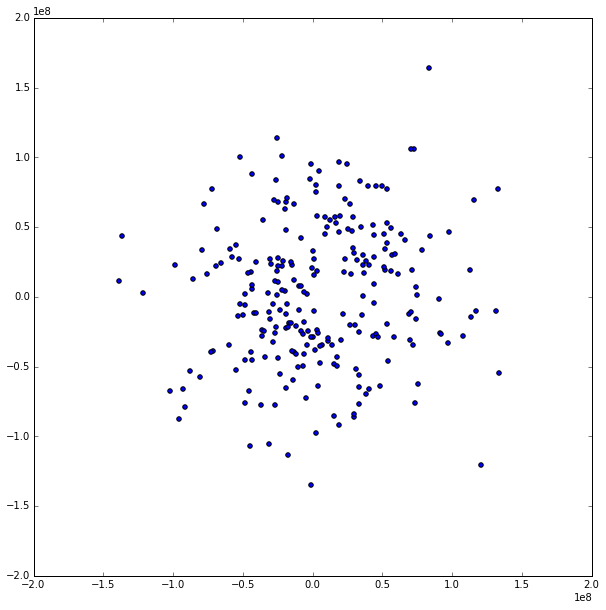

In [78]:
plt.figure(figsize=(10,10))
plt.scatter(xyDistribution[:,0], xyDistribution[:,1], c='b')
plt.xlim(-2e8, 2e8)
plt.ylim(-2e8, 2e8)
plt.plot()

In [79]:
def gravity(xyDistribution):
    
    global velocityDistribution
#    global xyDistribution
    global h
    
    deltaV = np.zeros_like(xyDistribution, dtype = np.float)
    for j in range(0, nParticles):
        for k in range(0, nParticles):
            if (k!=j):
                xdist = (xyDistribution[j,0]-xyDistribution[k,0])
                ydist = (xyDistribution[j,1]-xyDistribution[k,1])
#                print xyDistribution
#                print "xdist:", xdist
#                print(ydist)

                if(abs(xdist)<1e7):
#                    deltaV[j,0] -= -G*mDistribution[j]*xdist/((np.sqrt(xdist**2+ydist**2))**3)
                    deltaV[j,0] -= 0
#                    print "X less than smoothing"
                else:
                    deltaV[j,0] += -G*mDistribution[j]*xdist/((np.sqrt(xdist**2+ydist**2))**3)

                if(abs(ydist)<1e7):
#                    deltaV[j,1] -= -G*mDistribution[j]*ydist/((np.sqrt(xdist**2+ydist**2))**3)
                    deltaV[j,1] -= 0
#                    print "Y less than smoothing"
                else:
                    deltaV[j,1] += -G*mDistribution[j]*ydist/((np.sqrt(xdist**2+ydist**2))**3)
                    
    return deltaV

nb_gravity = nb.autojit(gravity)

In [80]:
# RK1 Parameters
t0 = time.time()
t = 0
#dt = 1e1
#stepN = 20

# Particle history
ParticlePositionHistory = np.zeros((stepN,nParticles,2))
ParticleRhoHistory = np.zeros((stepN, nParticles, 1))
xyDistributionOld = np.copy(xyDistribution)
# Velocity History
ParticleVelocityHistory = np.zeros((stepN,nParticles,2))

# Force history
forceHistory = np.zeros((stepN, 3))

for i in range(stepN):
    if i % 50 == 0:
        print "Time step", i
    if i == 2:
        rhoOld = np.copy(rhoDistribution)
    deltaVf = np.zeros_like(xyDistribution, dtype = np.float)
    
    t += 1
    ParticlePositionHistory[i,:,:] = xyDistribution
    ParticleVelocityHistory[i,:,:] = velocityDistribution
    
    deltaVf += nb_gravity(xyDistribution) 
#    print "\nAvg gravity", np.mean(deltaVf)
    forceHistory[i,0] = np.median(deltaVf)
    
    
#     deltaVf -= -gradP()/rhoDistribution[:,np.newaxis]
# #    print "Avg gravity + pressure", np.mean(deltaVf)
#     forceHistory[i,1] = np.mean(deltaVf)

#    deltaVf +=  -v*velocityDistribution**1
#    print "Avg damping:", np.mean(velocityDistribution)    
#    forceHistory[i,2] = np.mean(-v*velocityDistribution**1)
    
    velocityDistribution += dt*deltaVf    
    xyDistribution += dt*velocityDistribution

#    densityUpdate()
#    ParticleRhoHistory[i,:,:] = rhoDistribution[:,np.newaxis]
#    pressureDistribution = K*rhoDistribution**2

    ### --- DEBUGGING --- ###
#    print xyDistribution[0,0] - xyDistribution[1,0]


print(time.time()-t0)
#print(rhoDistribution-rhoOld)
#print(xyDistribution-xyDistributionOld) 


Time step 0
Time step 50
0.374099969864


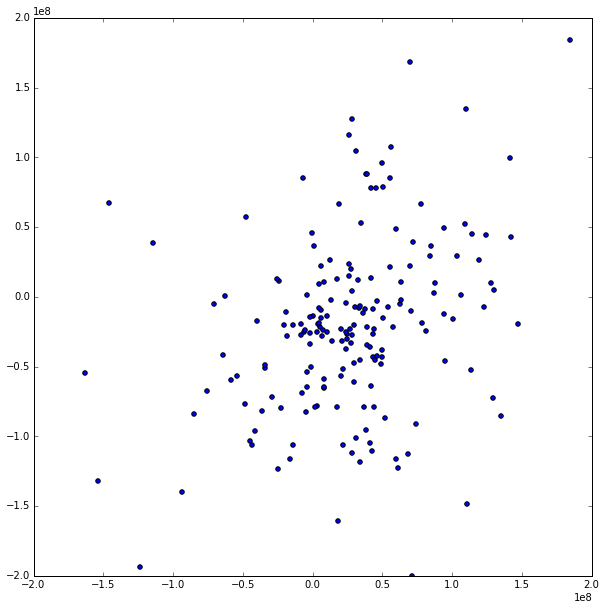

In [81]:
slider = FloatSlider(description='Time', min=1, max=stepN, step=1)

def update_plot():
    time=slider.value
    x = ParticlePositionHistory[time-1,:,0]
    y = ParticlePositionHistory[time-1,:,1]
    fig = plt.figure(figsize=(10,10))
    plt.scatter(x, y)
    plt.xlim(-2e8,2e8)
    plt.ylim(-2e8,2e8)

    clear_output(True)

slider.on_trait_change(update_plot, 'value')


display(slider)
update_plot()

[[ -2.61764265e+07  -8.32180829e+07]
 [  2.54293533e+07   1.80865682e+07]
 [  1.50313276e+08  -3.60745404e+07]
 [ -2.00503247e+08  -4.46183425e+07]
 [  1.81746482e+08   2.68030166e+08]
 [ -2.57943307e+07   1.04825105e+07]
 [ -2.35563284e+07   5.25524788e+07]
 [ -3.74363648e+05  -1.01723536e+08]
 [  1.95323450e+07  -1.15548619e+08]
 [  4.76248017e+07   7.00214083e+07]
 [ -7.13911635e+07   4.79172652e+07]
 [  9.28003335e+08   2.69481332e+07]
 [ -3.51898906e+08  -1.26767601e+08]
 [  3.63420448e+07   4.21967385e+07]
 [  1.00164914e+08  -7.04069122e+07]
 [ -5.22852463e+08   2.12067252e+09]
 [ -2.69743874e+07  -6.64645461e+06]
 [  2.52115429e+07   4.24773483e+07]
 [  7.33018473e+07   1.70789355e+07]
 [  4.50643208e+07   3.17638379e+07]
 [ -1.89099914e+08   1.31339221e+08]
 [  7.22295561e+07  -5.18893557e+07]
 [  3.50693743e+07   1.05080293e+08]
 [  1.00126827e+08  -7.85855372e+07]
 [ -6.17622079e+07  -2.72413480e+08]
 [  1.78436806e+08  -3.15185078e+08]
 [ -1.37904633e+07   7.83337702e+07]
 

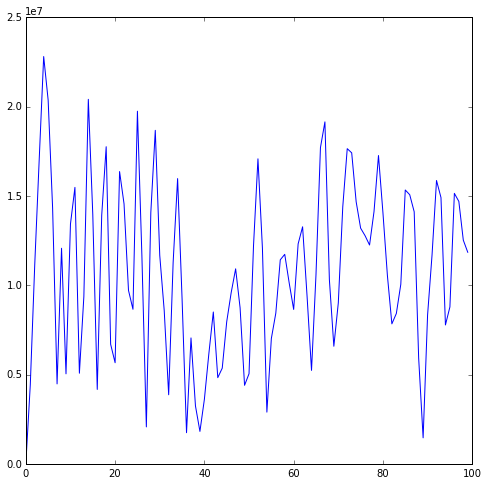

In [82]:
plt.figure(figsize=(8,8))
# plt.plot(range(stepN), forceHistory[:,0], label='gravity')
plt.plot(range(stepN), abs(np.sqrt((ParticleVelocityHistory[:,0,0])**2+(ParticleVelocityHistory[:,0,1])**2)))
print(xyDistribution-xyDistributionOld)

Velocity Asymptotes $\implies$ Force goes to zero (Good thing)